In [0]:
import h5py
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from xgboost import XGBClassifier

sns.set()
warnings.filterwarnings("ignore")

print (tf.test.gpu_device_name())
drive.mount('/content/drive/')

# Data Visualization & Preprocessing

In [3]:
df = pd.read_csv("/content/drive/My Drive/Colab/Imbalanced Data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Check for any null item
print (np.sum(df.isnull()))

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Fraud case: 0.17%
Non-fraud case: 99.83%




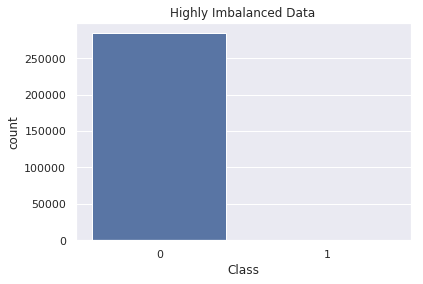

Training - fraud case: 0.17%
Testing - fraud case: 0.17%


In [6]:
print ("Fraud case: {:.2f}%".format(np.sum(df["Class"]==1)/len(df)*100))
print ("Non-fraud case: {:.2f}%".format(np.sum(df["Class"]==0)/len(df)*100))
print ("\n")
sns.countplot("Class",data=df)
plt.title("Highly Imbalanced Data")
plt.show()

# Split into training and validation set
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))

# Scaling should be done after train test split to prevent data leakage
# Scale time and amount
sc_time = RobustScaler()
sc_time.fit(x_train.iloc[:,0:1])
x_train.iloc[:,0:1] = sc_time.transform(x_train.iloc[:,0:1])
x_test.iloc[:,0:1] = sc_time.transform(x_test.iloc[:,0:1])

sc_amount = RobustScaler()
sc_amount.fit(x_train.iloc[:,-1:])
x_train.iloc[:,-1:] = sc_amount.transform(x_train.iloc[:,-1:])
x_test.iloc[:,-1:]= sc_amount.transform(x_test.iloc[:,-1:])

# **Case 1 - Deep Learning (Metrics & Cost Sensitive Training)**

1.   For fraud detection, recall is an important measure to validate model robustness in capturing all possible fraud cases. However, recall can only be improved at the expense of precision. F1-score can be used to achieve a balance.
1.   Deep neural network is able to extract important features during training process by updating weights and biases via backpropagation as compared to traditional machine learning method. Feature extraction techniques such as PCA are to be applied prior to the training process of machine learning. 
1.   Due to imbalanced data, SMOTE, synthetic minority over sampling technique is applied. SMOTE can be implemented as followed:
  * Create samples from minority class instead of creating copies.
  * Select 2 or more similar instances using distance measure and alter an instance one attribute at a time by a random amount within difference to the neighbouring instance.
1.   SMOTE shall be used in cross validation stage or after train_test_split (applied on training set only) to prevent data leakage.
1.   6 cases:
  * Default - ANN (Imbalanced data)
  * Case 1.1 - Metrics - ANN with f1-score and fl-loss (Imbalanced data)
  * Case 1.2 - Metrics - ANN with recall and recall-loss (Imbalanced data)
  * Case 1.3 - Metrics & sampling - ANN with f1-score and fl-loss undersampling (balanced data)
  * Case 1.4 - Sampling - ANN with wrong SMOTE (imbalanced testing, balanced training)
  * Case 1.5 - Sampling - ANN with right SMOTE (imbalanced testing, balanced training)
  * Case 1.6 - Cost sensitive training - ANN with class weight (imbalanced data)
1.   Summary:
  * Standardization shall be applied to training set and same scaling to be used on test set to prevent data leakage
  * Metrics shall be adjusted to train ANN. F1-score achieves balance between recall and precision (trade off relationship between recall and precision).
  * Probability threshold to classify item as fraud can be adjusted. The higher the probability, the lower recall, the higher precision.
  * Model shall be trained with train set with same distribution as test set, if not covariate shift. Trained model will be good with training set but perform poorly with test set.
  * SMOTE is to applied during cross validation to prevent data leakage to validation set, resulting in overfitting (val_accuracy=1).
  * Undersampling helps achieve balanced data and create same distribution of training and test set. However, it is not advisable as it increases the risk of losing information and in practical the test data is still not balanced (Poor performace of trained model with test set).
  * Metrics (F1-score) > sampling
  * Metrics, sampling, other algorithms for anomaly detection (random forest, autoencoder), cost sensitive training (class weight, penalized SVM)


**Default - ANN (Imbalanced data)**

In [7]:
# Training, validation and testing set have the same imbalanced distribution

input_size = x_train.shape[1]
epochs = 20
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

checkpoint = ModelCheckpoint(best_model_dir, monitor="val_loss", save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________

Train on 182276 samples, validate on 45569 samples
Epoch 1/20
182276/182276 [==============================] - 4s 25us/step - loss: 0.1205 - acc: 0.9466 - val_loss: 0.0072 - val_acc: 0.9991
Epoch 2/20
182276/182276 [==============================] - 1s 7us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0049 - val_acc: 0.9993
Epoch 3/20
182276/182276 [==============================] - 1s 7us/step - loss: 0.

precision: 0.93
recall: 0.77
f1 score: 0.84


Confusion matrix:
 [[56858     6]
 [   23    75]]




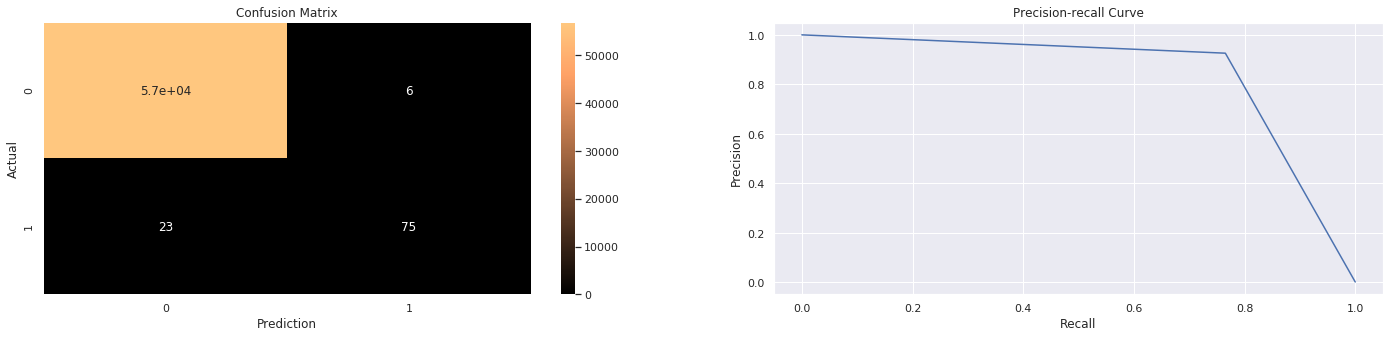

In [10]:
classifier = load_model(best_model_dir)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.1 - ANN with f1-score and fl-loss (Imbalanced data)**

In [11]:
# Monitor f1-score and select model with best f1-score
# Training, validation and testing set have the same imbalanced distribution

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    # Each row represents one observation with multiple classes
    # Summation should be done along the column --> axis = 0
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp/(tp+fp+K.epsilon())
    r = tp/(tp+fn+K.epsilon())
    f1 = 2*p*r/(p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

  
input_size = x_train.shape[1]
epochs = 50
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.1_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss=[f1_loss], metrics=["accuracy", f1])
classifier.summary()

checkpoint = ModelCheckpoint(best_model_dir, monitor="val_f1", save_best_only=True, save_weights_only=False, mode="max")
earlystop = EarlyStopping(monitor="val_f1", patience=20)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 182276 samples, validate on 45569 samples
Epoch 1/50
182276/182276 [==============================] - 2s 10us/step - loss: 0.8773 - acc: 0.9527 - f1: 0.4398 - val_loss: 0.2800 - val_acc: 0.9993 - val_f1: 0.7984
Epoch 2/50
182276/182276 [==============================] - 1s 7us/step - loss: 0.2025 - acc: 0.9994 - f1: 0.8102 - val_loss: 0.1699 - val_acc: 0.9994 - val_f1: 0.8301
Epoch 3/50
182276/182276 [==============================] - 1s 7us/step - loss: 0.1891 - acc: 0.9994 - f1: 0.8122 - val_lo

precision: 0.83
recall: 0.80
f1 score: 0.81


Confusion matrix:
 [[56848    16]
 [   20    78]]




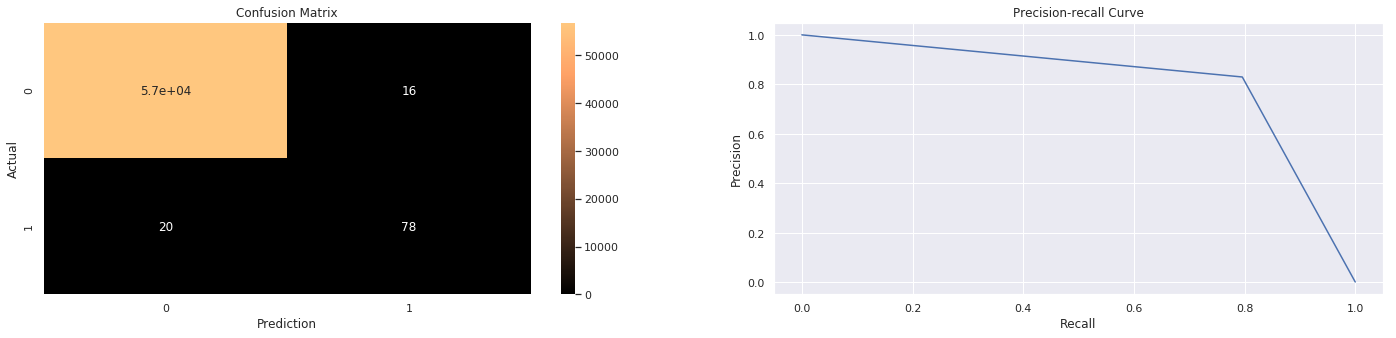

In [12]:
classifier = load_model(best_model_dir, custom_objects={"f1_loss":f1_loss, "f1":f1})
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.2 - ANN with recall and recall-loss (Imbalanced data)**

In [13]:
# Training, validation and testing set have the same imbalanced distribution

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    # Each row represents one observation with multiple classes
    # Summation should be done along the column --> axis = 0
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp/(tp+fp+K.epsilon())
    r = tp/(tp+fn+K.epsilon())
    f1 = 2*p*r/(p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(r)

def recall_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(r)

  
input_size = x_train.shape[1]
epochs = 50
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.2_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss=[recall_loss], metrics=["accuracy", recall])
classifier.summary()

checkpoint = ModelCheckpoint(best_model_dir, monitor="val_recall", save_best_only=True, save_weights_only=False, mode="max")
earlystop = EarlyStopping(monitor="val_recall", patience=20)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 182276 samples, validate on 45569 samples
Epoch 1/50
182276/182276 [==============================] - 2s 10us/step - loss: 0.0354 - acc: 0.0320 - recall: 0.9831 - val_loss: 0.0047 - val_acc: 0.0019 - val_recall: 1.0000
Epoch 2/50
182276/182276 [==============================] - 1s 7us/step - loss: 9.6401e-04 - acc: 0.0017 - recall: 1.0000 - val_loss: 0.0020 - val_acc: 0.0019 - val_recall: 1.0000
Epoch 3/50
182276/182276 [==============================] - 1s 7us/step - loss: 3.3927e-04 - acc: 0.00

precision: 0.00
recall: 1.00
f1 score: 0.00


Confusion matrix:
 [[    0 56864]
 [    0    98]]




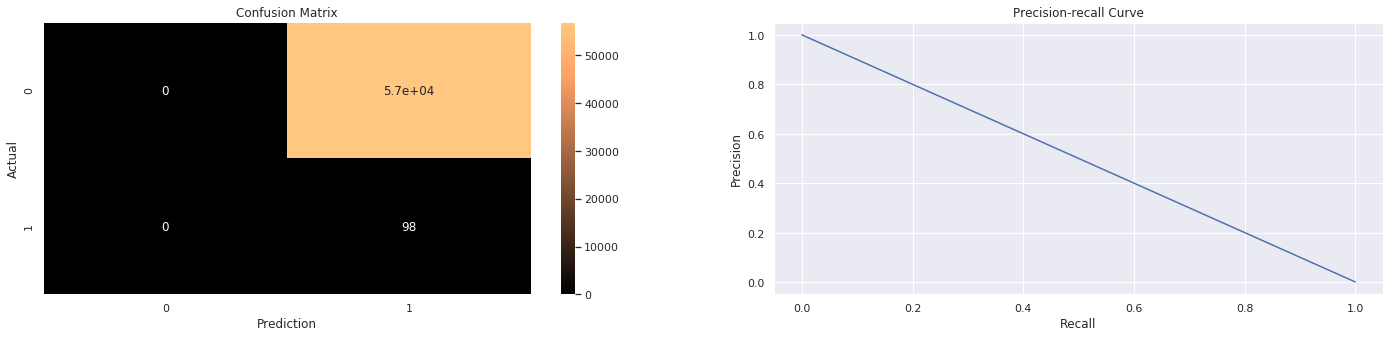

In [14]:
classifier = load_model(best_model_dir, custom_objects={"recall_loss":recall_loss, "recall":recall})
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.3 - ANN with f1-score and fl-loss undersampling (balanced data)**

In [18]:
# Undersampling might result in loss of information
# Monitor f1-score and select model with best f1-score
# Training, validation and testing set have the same balanced distribution

# Shuffle the data and select equal number of cases with class 0 and 1 respectively
df_shuffled = df.sample(frac=1)
df_reduced_fraud = df_shuffled[df_shuffled["Class"]==1]
df_reduced_nonfraud = df_shuffled[df_shuffled["Class"]==0][:len(df_reduced_fraud)]
df_reduced = pd.concat([df_reduced_fraud, df_reduced_nonfraud])
print ("Total sample size: {}".format(len(df_shuffled)))
print ("Fraud case reduced sample size: {}".format(len(df_reduced_fraud)))
print ("Non-fraud case reduced sample size: {}".format(len(df_reduced_nonfraud)))
print ("Reduced sample size: {}".format(len(df_reduced)), "\n")

x_reduced = df_reduced.iloc[:,:-1]
y_reduced = df_reduced.iloc[:,-1]
x_reduced_train, x_reduced_test, y_reduced_train, y_reduced_test = train_test_split(x_reduced, y_reduced, test_size=0.2, random_state=42)
print ("Percentage of cases with class 1 for training:{:.3f}".format(np.sum(y_reduced_train==1)/len(y_reduced_train)))
print ("Percentage of cases with class 1 for testing:{:.3f}".format(np.sum(y_reduced_test==1)/len(y_reduced_test)), "\n")

# Scale time and amount
sc_time = RobustScaler()
sc_time.fit(x_reduced_train.iloc[:,0:1])
x_reduced_train.iloc[:,0:1] = sc_time.transform(x_reduced_train.iloc[:,0:1])
x_reduced_test.iloc[:,0:1] = sc_time.transform(x_reduced_test.iloc[:,0:1])

sc_amount = RobustScaler()
sc_amount.fit(x_train.iloc[:,-1:])
x_reduced_train.iloc[:,-1:] = sc_amount.transform(x_reduced_train.iloc[:,-1:])
x_reduced_test.iloc[:,-1:]= sc_amount.transform(x_reduced_test.iloc[:,-1:])

Total sample size: 284807
Fraud case reduced sample size: 492
Non-fraud case reduced sample size: 492
Reduced sample size: 984 

Percentage of cases with class 1 for training:0.499
Percentage of cases with class 1 for testing:0.503 



In [17]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    # Each row represents one observation with multiple classes
    # Summation should be done along the column --> axis = 0
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp/(tp+fp+K.epsilon())
    r = tp/(tp+fn+K.epsilon())
    f1 = 2*p*r/(p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
  
input_size = x_train.shape[1]
epochs = 50
batch_size = 100
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.3_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss=[f1_loss], metrics=["accuracy", f1])
classifier.summary()

checkpoint = ModelCheckpoint(best_model_dir, monitor="val_f1", save_best_only=True, save_weights_only=False, mode="max")
earlystop = EarlyStopping(monitor="val_f1", patience=20)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_reduced_train, y_reduced_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 629 samples, validate on 158 samples
Epoch 1/50
629/629 [==============================] - 1s 1ms/step - loss: 0.3032 - acc: 0.6900 - f1: 0.6460 - val_loss: 0.2372 - val_acc: 0.8038 - val_f1: 0.7920
Epoch 2/50
629/629 [==============================] - 0s 77us/step - loss: 0.1989 - acc: 0.8490 - f1: 0.8317 - val_loss: 0.1612 - val_acc: 0.8671 - val_f1: 0.8696
Epoch 3/50
629/629 [==============================] - 0s 76us/step - loss: 0.1418 - acc: 0.8903 - f1: 0.8828 - val_loss: 0.1124 - val_acc: 

precision: 0.93
recall: 0.96
f1 score: 0.95


Confusion matrix:
 [[91  7]
 [ 4 95]]




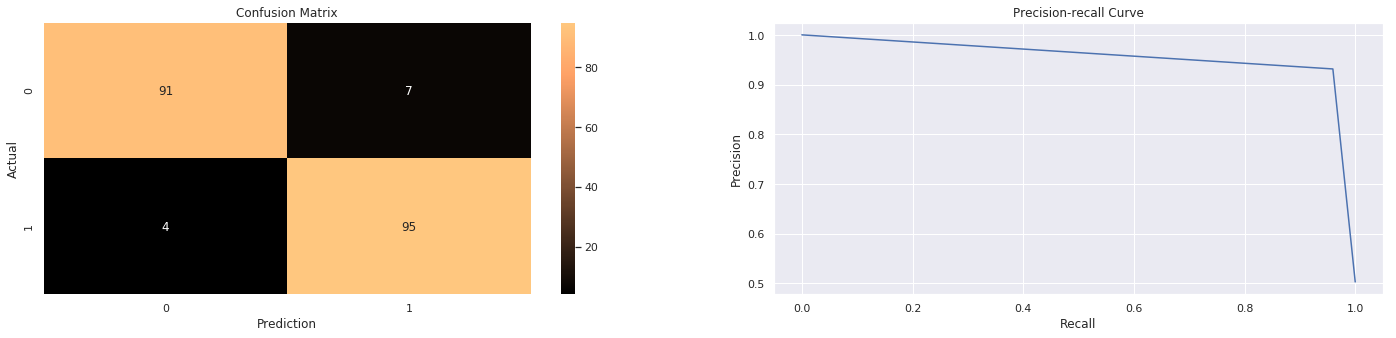

In [19]:
classifier = load_model(best_model_dir, custom_objects={"f1_loss":f1_loss, "f1":f1})
y_pred = classifier.predict(x_reduced_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_reduced_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_reduced_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_reduced_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_reduced_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_reduced_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.4 - ANN with wrong SMOTE (imbalanced testing, balanced training)**

In [22]:
# SMOTE is applied before cross validation
# Data is leaked to validation set, resulting in overfitting (validation_accuracy is high)
# Covariate shift - Training, validation have the same but different distribution from testing set

# Oversampling minority class using SMOTE and training set is used for validation during training
smote = SMOTE(sampling_strategy="minority", random_state=42)
x_train_smote, y_train_smote = smote.fit_sample(x_train, y_train)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_train_smote==1)/len(y_train_smote)))
print ("Percentage of cases with class 1 for testing:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")
       
input_size = x_train_smote.shape[1]
epochs = 20
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.4_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

# Note that oversampled training set is split for validation and result in data leakage and overfitting
# Note the high validation accuracy
checkpoint = ModelCheckpoint(best_model_dir, monitor="val_loss", save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_train_smote, y_train_smote, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for testing:0.0017 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10000)             310000    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 363921 samples, validate on 90981 samples
Epoch 1/20
363921/363921 [==============================] - 3s 9us/step - loss: 0.1625 - acc: 0.9393 - val_loss: 0.1235 - val_acc: 0.9354
Epoch 2/20
363921/363921 [==============================] - 2s 7us/step - loss: 0.0623 - acc: 0.9751 - val_loss: 0.0763 - val_acc: 0.9639
Epoch 3/20
363921/363921 [==============================] - 2s 7us/step - lo

precision: 0.62
recall: 0.85
f1 score: 0.72


Confusion matrix:
 [[56814    50]
 [   15    83]]




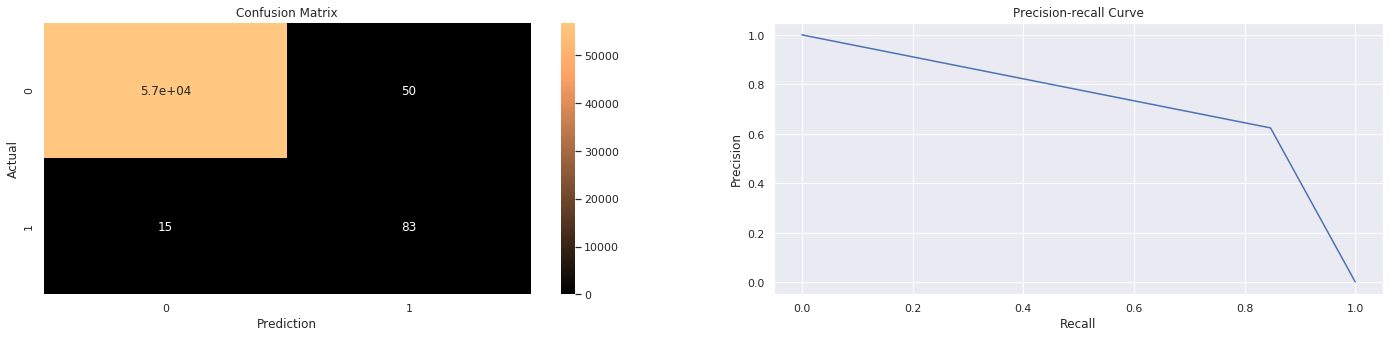

In [23]:
classifier = load_model(best_model_dir)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.5 - ANN with right SMOTE (imbalanced testing, balanced training)**

In [24]:
# SMOTE is applied to sub-training set to prevent data leakage
# Covariate shift - Training, validation have the same but different distribution from testing set

# Split training set into sub-training set for SMOTE and validation set to prevent data leakage
x_subtrain, x_val, y_subtrain, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Oversampling minority class using SMOTE
smote = SMOTE(sampling_strategy="minority", random_state=42)
x_subtrain_smote, y_subtrain_smote = smote.fit_sample(x_subtrain, y_subtrain)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_subtrain_smote==1)/len(y_subtrain_smote)))
print ("Percentage of cases with class 1 for testing:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")

input_size = x_subtrain_smote.shape[1]
epochs = 20
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.5_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

checkpoint = ModelCheckpoint(best_model_dir, monitor="val_loss", save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_subtrain_smote, y_subtrain_smote, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for testing:0.0017 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10000)             310000    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 363892 samples, validate on 45569 samples
Epoch 1/20
363892/363892 [==============================] - 3s 9us/step - loss: 0.1680 - acc: 0.9204 - val_loss: 0.0650 - val_acc: 0.9825
Epoch 2/20
363892/363892 [==============================] - 2s 7us/step - loss: 0.0642 - acc: 0.9762 - val_loss: 0.0497 - val_acc: 0.9855
Epoch 3/20
363892/363892 [==============================] - 2s 7us/step - lo

precision: 0.53
recall: 0.86
f1 score: 0.66


Confusion matrix:
 [[56790    74]
 [   14    84]]




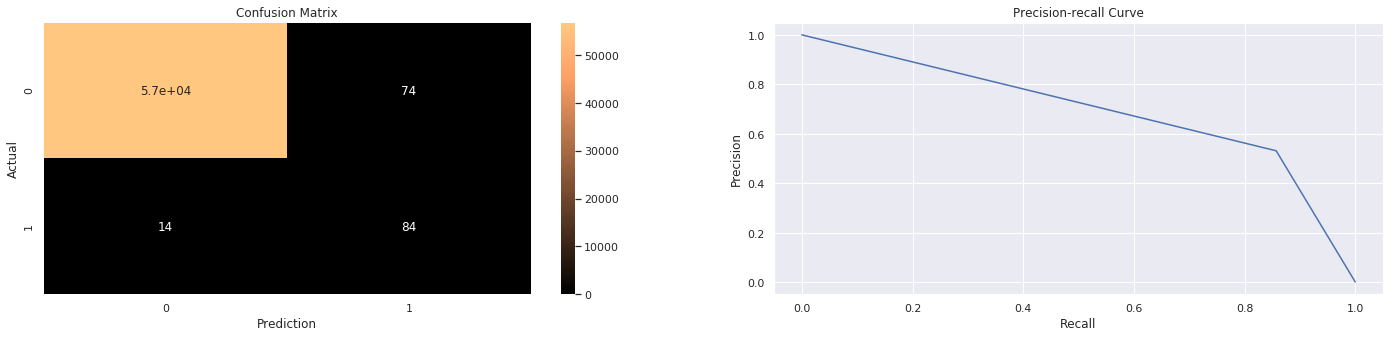

In [25]:
classifier = load_model(best_model_dir)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 1.6 - ANN with class weight (imbalanced data)**

In [26]:
# Training, validation and testing set have the same imbalanced distribution

input_size = x_train.shape[1]
epochs = 20
batch_size = 10000
best_model_dir = "/content/drive/My Drive/Colab/Imbalanced Data/case1.6_credit_card_fraud_model.hdf5"

classifier = Sequential()
classifier.add(Dense(10000, activation="relu", input_shape=(input_size,)))
classifier.add(Dense(1, activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

class_weight = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
checkpoint = ModelCheckpoint(best_model_dir, monitor="val_loss", save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, earlystop]
classifier.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True, class_weight=class_weight)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10000)             310000    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Train on 182276 samples, validate on 45569 samples
Epoch 1/20
182276/182276 [==============================] - 2s 13us/step - loss: 0.1142 - acc: 0.9688 - val_loss: 0.0071 - val_acc: 0.9991
Epoch 2/20
182276/182276 [==============================] - 1s 7us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0048 - val_acc: 0.9993
Epoch 3/20
182276/182276 [==============================] - 1s 7us/step - loss: 0.0044 - acc: 0.9994 - val_loss: 0.0038 - val_acc: 0.9993
Epoch 4/20
182276/182276 [=================

precision: 0.92
recall: 0.78
f1 score: 0.84


Confusion matrix:
 [[56857     7]
 [   22    76]]




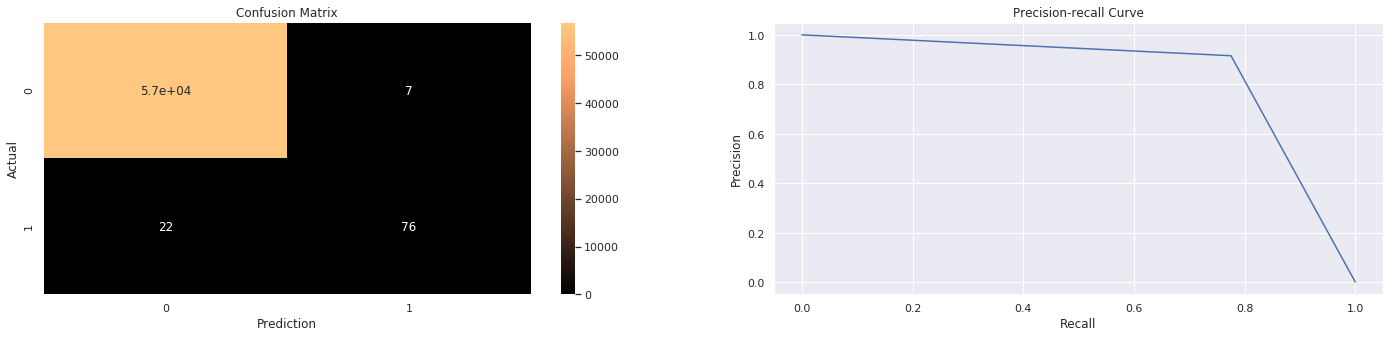

In [27]:
classifier = load_model(best_model_dir)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

# **Case 2 - Random Forest (Gradient Boosting)**

1.   Random forest is built on the basis of decision tree. Decision tree is constructed of root, decision, leaf/terminal node. The node is split whenever there is reduction in gini impurity and entropy (categorical feature data)/ mean square error (numerical data). 
2.   For categorical feature data, the best split is decided selecting the categorical feature with lowest gini impurity.
1.   For numerical feature data, the threshold will be decided first for each numerical feature data by testing out all the available value. Value returning lowerst mean square error is selected as the threshold. The best split is then decided comparing the mean square error of respective numerical feature data with the best threshold value.
2.   For categorical output, the output will be the value run down the tree. For numerical output, the output will be the average value of those observation in that particular leaf/ terminal node. Since it is the average value, the prediction is inaccurate for output value lies at the end of the distribution.
1.   Random forest is ensemble bagging method, gradient boosting is ensemble boosting method (but build on the basis of random forest).
2.   Random forest has full grown trees (low bias high variance(overfitting)) and decision is made based on voting. Each tree is grown in parallel independent of each other using the bootstrapped data. Thus, random forest has minimum impact to imbalanced data.
1.   Gradient boosting has restricted size tree (high bias low variance) using the entire dataset and it is sequentially growing. It starts with a leaf node with average value of output for numerical data or log(adds) for categorical data. Residual is found by substrating the initial value with actual value. The subsequent tree is built to find the residual. The output will be the initial value + learning rate*value run down the tree.
1.   Random forest is independent of feature scaling since the gini impurity or mean square error for one particular feature is calculated irrespectively of value of other feature
1.   4 cases:
  * Default - RF (Imbalanced data)
  * Case 2.1 - Gradient Boosting (Imbalanced data)
  * Case 2.2 - Gradient Boosting with hyperparameter tuned (Imbalanced data) 
  * Case 2.3 - Extreme Gradient Boosting with Gradient Boosting hyperparameter and imbalanced data 
1.   Summary:
  * Random forest is a good machine learning method to counter imbalanced data. 
  * With additive training/ sequential growing method, gradient boosting/ XGBoost is able to avchieve high f1-score. With regularization loss, XGBoost achieve the highest f1-score






In [28]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))

Training - fraud case: 0.17%
Testing - fraud case: 0.17%


**Default - RF with imbalanced data**

precision: 0.95
recall: 0.78
f1 score: 0.85


Confusion matrix:
 [[56860     4]
 [   22    76]]




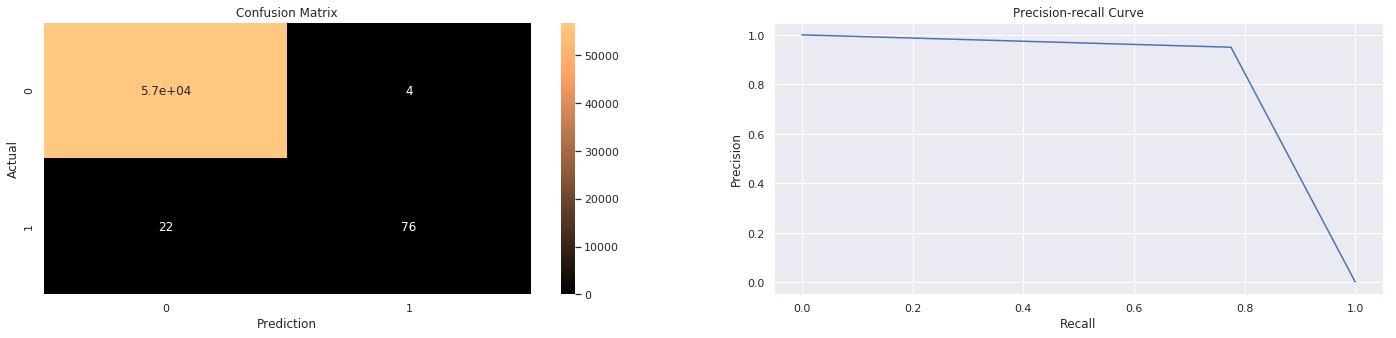

In [29]:
classifier = RandomForestClassifier(n_estimators=10, bootstrap=False)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 2.1 - Gradient Boosting with imbalanced data**

precision: 0.83
recall: 0.81
f1 score: 0.82


Confusion matrix:
 [[56848    16]
 [   19    79]]




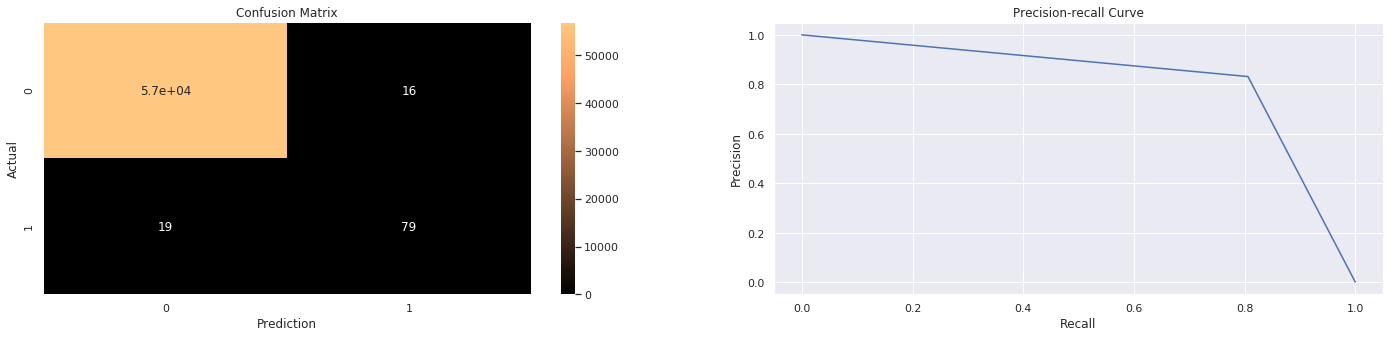

In [30]:
classifier = GradientBoostingClassifier(n_estimators=10, max_depth=5)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 2.2 - Gradient Boosting with hyperparameter tuned and imbalanced data**

In [0]:
classifier = GradientBoostingClassifier()
  
parameter = {"learning_rate":[0.001, 0.01, 0.1],
             "n_estimators":[10, 50, 100, 200],
             "min_samples_leaf":[1, 2, 5],
             "max_depth":[3, 5, 10]}

# scoring option for gridsearchcv
# https://scikit-learn.org/stable/modules/model_evaluation.html
# f1 - binary, f1_micro, f1_macro, f1_weighted - multiple classes
grid_search = GridSearchCV(estimator=classifier, param_grid=parameter, cv=5, scoring="f1")
grid_search.fit(x_train, y_train)

classifier = grid_search.best_estimator_

y_pred = classifier.predict(x_test)
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

precision: 0.96
recall: 0.80
f1 score: 0.87


Confusion matrix:
 [[56861     3]
 [   20    78]]




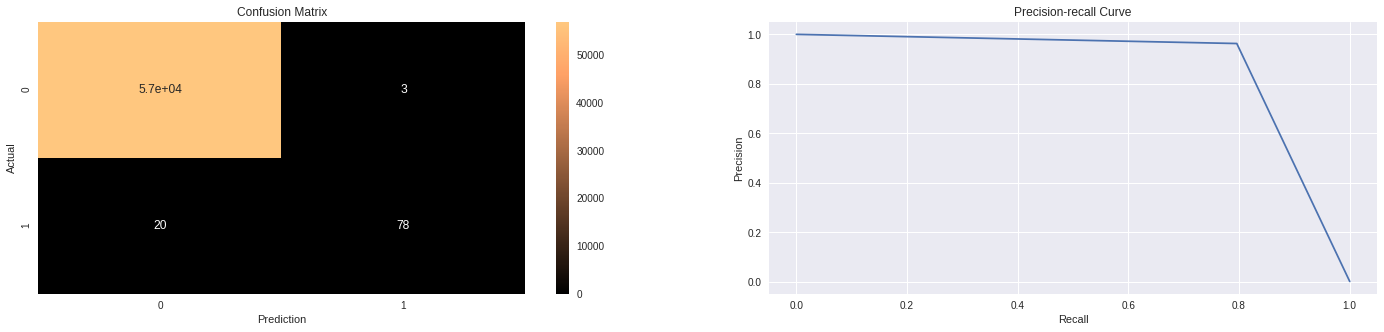

In [0]:
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=5)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

**Case 2.3 - Extreme Gradient Boosting with Gradient Boosting hyperparameter and imbalanced data**

precision: 0.98
recall: 0.81
f1 score: 0.88


Confusion matrix:
 [[56862     2]
 [   19    79]]




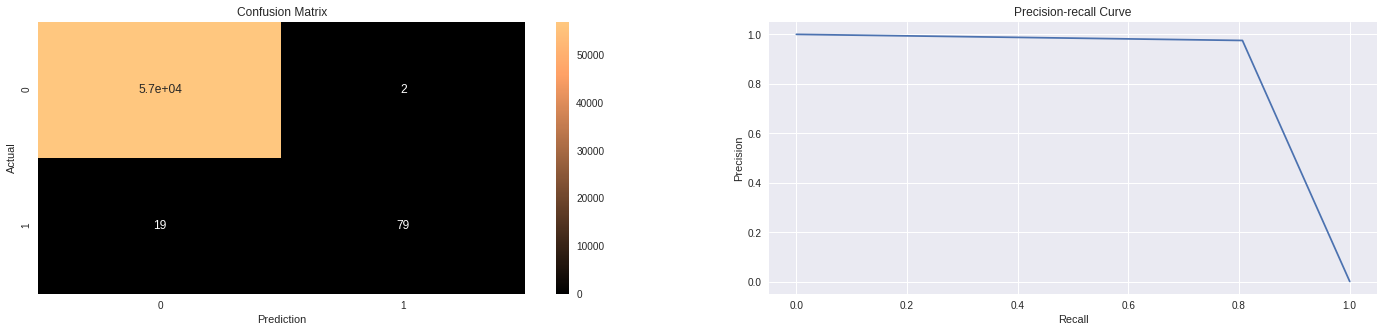

In [0]:
classifier = XGBClassifier(n_estimators=100, eta=0.01, max_depth=5)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("\n")

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")

fig, ax = plt.subplots(1, 2, figsize=(24,5))

# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()